# Travelling Salesman Problem - A Genetic Algorithm Approach

Implement a genetic algorithm using PyGad (Ahmed Fawzy Gad, 2021 https://pygad.readthedocs.io/en/latest/) in order to find a solution to the Travelling Salesman Problem (TSP).
- TSP constraints:
    - You must start and end at the same city
    - Every other city you may visit only once
    - Minimize the distance travelled

Best solution found for tsp2.csv dataset:

    [26. 13. 28.  1.  2. 46. 33. 10. 25. 44. 49. 48. 30. 47. 41. 42. 12. 14.
    20. 11. 18. 17. 37. 32. 31. 19. 15. 16. 34. 35. 36.  8.  9. 22. 38. 39.
    40. 50. 21. 23. 24. 45. 43.  5.  3.  7. 29.  4.  6. 27. 26.] 

    Fitness = 0.004081617854585802 Distance = 245.0008882817078


## Setup

In [14]:
import pandas as pd
import math
import numpy as np
import random
import pygad
from datetime import datetime
import matplotlib.pyplot as plt

#get city data
# TSP = pd.read_csv('tsp1.csv', index_col=0, header=0)
TSP = pd.read_csv('tsp2.csv', index_col=0, header=0)

#get max # of cities
MAX_CITIES = len(TSP.index)

## Functions

In [15]:
# distance between two cities
def e_dist(A, B):
    return math.sqrt((A[1]-B[1])**2 + (A[0]-B[0])**2)

# generates a random solution
def solution():
    solArr = []
    for i in range(MAX_CITIES):
        solArr.append(int(i + 1))
    random.shuffle(solArr)
    return solArr

# fitness function
# '-1' is used to change the 1-based city index to the 0-based array
def trip_dist(solution, solution_idx):
    dist = 0
    for i in range(MAX_CITIES - 1):
        #get array shifted city locations
        x = int(solution[i] - 1)
        y = int(solution[i + 1] - 1)
        dist += LOOKUP[x][y]
    first = int(solution[0] - 1)
    last = int(solution[MAX_CITIES - 1] - 1)
    dist += LOOKUP[first][last]
    return 1/dist

# called after each generation
# returning the string "stop" will terminate the genetic algorithm
def on_generation(g):
    #comment out for multiple runs to reduce amount of information output
    print(datetime.now(), "Generation:", g.generations_completed, "\tLast Solution:", round(1/g.last_generation_fitness[0],4))

    #determines whether or not to stop (no improvement after x iterations)
    x = 500
    if(stop_gen(g, x)):
        return "stop"

# determine whether to stop a generation after x iterations of no improvement
def stop_gen(g, x):
    if(g.generations_completed > x):
        max_index = g.generations_completed - 1
        curr_fitness = g.best_solutions_fitness[max_index]
        x_back_fitness = g.best_solutions_fitness[max_index - x]
        if(math.isclose(curr_fitness, x_back_fitness, abs_tol=0.00003)):
            return True
    return False

# print the solution
def print_sol(g):
    dist = trip_dist(g, 1)
    print("Fitness = {} Distance = {}".format(dist, 1/dist))

# calculate the distance between every city
# creates a 2d array for the number of cities
# need to use -1 to convert between the 0 indexed range and the 1 indexed city numbering system
def all_distances():
    x = [[0 for i in range(MAX_CITIES)] for y in range(MAX_CITIES)]
    for i in range(1, MAX_CITIES + 1):
        for j in range(1, MAX_CITIES + 1):
            x[i - 1][j - 1] = e_dist(TSP.loc[i], TSP.loc[j])
    return x

#print the best route onto a graph
#modified from https://www.kite.com/python/answers/how-to-make-a-connected-scatter-plot-in-matplotlib-in-python
def print_route(s):
   x_coordinates = []
   y_coordinates = []
   for i in range(MAX_CITIES + 1):  #+1 because we add the first city to the end before calling
         city  = TSP.loc[s[i]]
         x_coordinates.append(city[0])
         y_coordinates.append(city[1])
   plt.scatter(x_coordinates, y_coordinates)
   plt.plot(x_coordinates, y_coordinates)
   plt.xlabel("x distance")
   plt.ylabel("y distance")
   plt.title("Best Solution Route")

#2-D array with all of the distances between cities
LOOKUP = all_distances()

## GA

Modified from Queens(1).ipynb, Alan Fedoruk, for COMP 3625, Date: Oct 11, 2021
https://courseware.mymru.ca/bbcswebdav/pid-5900968-dt-content-rid-70860881_1/xid-70860881_1

- Solutions per population
    - Too low resulted in local minimum
    - Too high increased computation time

- Generations
    - Too low the plateau of the fitness funciton was never reached -> the optimal solution for the set of constraints was never found
    - Too high there were no more improvements to be found as the fitness function had reached its peak -> wasted computation time
        - The stop_gen function corrects for this

- Lower number of parents mating resulted in too much "elitism"
    - by mating with only a small subset of parents, we were stifling diversity and only getting the positive traits of a small portion of the population
        - doesn't play to the strengths of evolution in a genetic algorithm
        
- Parent selection type
   - ranked appears to get to the local optimum faster, although steady state seems to get better results overall

- Adaptive mutation helped jump start the fitness and narrow the solution space quicker
    - One of the problems with random mutation is that we can throw away too much of a good solution and not enough of a bad one (see https://i2.wp.com/neptune.ai/wp-content/uploads/Mutation-probability.jpg?resize=768%2C254&ssl=1 for a excellent visual). Adaptive mutation aims to solve this by having a larger mutation percentage for all solutions worse than average, and a lower mutation percentage for all solutions better than average

In [16]:
def ga():
   #assign the fitness function
   fitness_function = trip_dist

   #how many generations to iterate through
   #set this high and let the stop_gen funciton determine whether to end
   #  make sure to set the number of iterations in stop_gen sufficently high for your dataset
   num_generations = 5000

   #size of the population
   sol_per_pop = 250

   #solution space
   num_genes = MAX_CITIES

   #solution range
   gene_space = range(1, MAX_CITIES + 1)

   #mate with the top x% of the population
   #25% has been a good medium
   mating_percent = 25
   num_parents_mating = math.ceil(sol_per_pop * mating_percent / 100)
   
   #keep the top x% of the population for the next generation
   #1% works good for larger population (>1000), else 5% is good
   keep_percent = 5
   keep_parents = math.ceil(sol_per_pop * keep_percent / 100)

   #choose how to select parents
   # parent_selection_type = "sss"
   parent_selection_type = "rank"

   #crossover the data from single point and two point was indistinguishable
   #but two point was more resource intensive
   crossover_type = "single_point"
   # crossover_type = "two_points"

   #how to implement mutation
   mutation_type = "adaptive"

   #will throw warning if percent * MAX_CITIES < 1 (i.e. in tsp1.csv)
   #[20, 5] has produced the best results
   mutation_percent_genes = [20, 5]
   
   #initialize the genetic algorithm parameters
   ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        gene_space=gene_space,
                        on_generation=on_generation,
                        allow_duplicate_genes=False)

   #run an instance of the genetic algorithm
   ga_instance.run()

   #plot the fitness over time
   ga_instance.plot_fitness()

   #save the best result
   s, fit, s_i = ga_instance.best_solution()

   #modify the best result array for printing(need to add the last city = first city to be displayed correctly)
   s_print = s
   s_print = np.append(s_print, s_print[0])

   #print a map of the best solution route
   print_route(s_print)

   #print the best route
   print("Best Route:\n",s_print,"\n")

   #return the best solution
   return s

## Main

Runs the genetic algorithm and outputs the best solution found.



2022-01-12 22:00:03.285225 Generation: 1 	Last Solution: 782.7635
2022-01-12 22:00:03.582603 Generation: 2 	Last Solution: 759.1908
2022-01-12 22:00:03.850297 Generation: 3 	Last Solution: 739.6792
2022-01-12 22:00:04.104646 Generation: 4 	Last Solution: 724.3089
2022-01-12 22:00:04.368613 Generation: 5 	Last Solution: 718.0169
2022-01-12 22:00:04.634856 Generation: 6 	Last Solution: 718.0169
2022-01-12 22:00:04.892906 Generation: 7 	Last Solution: 661.8279
2022-01-12 22:00:05.153425 Generation: 8 	Last Solution: 660.2557
2022-01-12 22:00:05.391678 Generation: 9 	Last Solution: 653.543
2022-01-12 22:00:05.637123 Generation: 10 	Last Solution: 648.8108
2022-01-12 22:00:05.882444 Generation: 11 	Last Solution: 638.9908
2022-01-12 22:00:06.107880 Generation: 12 	Last Solution: 617.8184
2022-01-12 22:00:06.392745 Generation: 13 	Last Solution: 617.8184
2022-01-12 22:00:06.643284 Generation: 14 	Last Solution: 596.1794
2022-01-12 22:00:06.881846 Generation: 15 	Last Solution: 596.1794
202

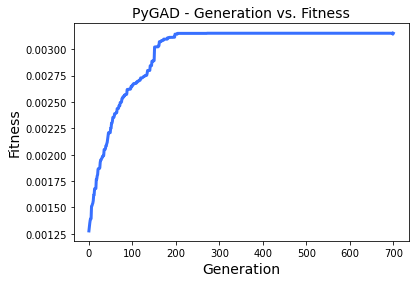

Best Route:
 [10. 40. 39. 38. 50. 21. 37. 47. 42. 41. 30. 49. 48. 32. 15. 16. 44. 45.
  3.  7. 27.  2.  1. 28. 46.  8.  9. 22. 11. 20. 14. 12. 19. 25. 24. 23.
 18. 17. 36. 35. 34. 31. 43.  5. 29.  4. 26. 13.  6. 33. 10.] 

Fitness = 0.00314226284217764 Distance = 318.24199636558205




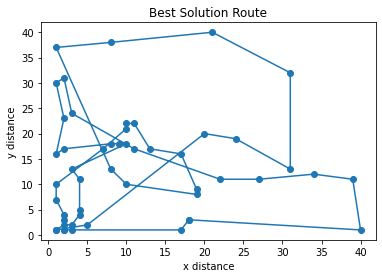

In [17]:
#run once
print("\n")
print_sol(ga())
print("\n")

##run x times
# x = 5
# print(str(x), "runs:\n")
# for i in range(10):
#     print("\n")
#     print_sol(ga())
#     print("\n")